In [1]:
import glob
import os
import json
import datetime
import time

import torch
import pandas as pd
import numpy as np
import nibabel as nib

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

#from fastai.vision.all import *
import fastMONAI.vision_all
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from scipy import interpolate

from useful_functions import *
from utils import *

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is available. Fastai will use the GPU.")
else:
    device = torch.device("cpu")
    print("GPU is NOT available. Fastai will use the CPU.")

GPU is available. Fastai will use the GPU.


In [3]:
bids_dir = "bids"

In [4]:
session_dirs = []
for json_path in sorted(glob.glob(os.path.join(bids_dir, "sub*", "ses*", "anat", "*echo-01*mag*json"))):
    with open(json_path, 'r') as json_file:
        json_data = json.load(json_file)
        if json_data['ProtocolName'] in ["wip_iSWI_fl3d_vibe_TRY THIS ONE"]:#, "wip_iSWI_fl3d_vibe", "wip_iSWI_fl3d_vibe_TRY THIS ONE"]:
            session_dirs.append(os.sep.join(os.path.split(json_path)[0].split(os.sep)[:-1]))
print(f"{len(session_dirs)} sessions found.")

# remove all sessions with 'sub-z0449294' in the path
session_dirs = sorted(set([s for s in session_dirs if 'sub-z0449294' not in s]))

print(f"{len(session_dirs)} sessions found.")

27 sessions found.
25 sessions found.


In [5]:
extra_files = sum((glob.glob(os.path.join(session_dir, "extra_data", "*.nii*")) for session_dir in session_dirs), [])

qsm_files2 = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*real.nii*")) for session_dir in session_dirs), []))
qsm_files = [x for x in sorted(glob.glob(os.path.join("out/qsm/*.nii"))) if 'sub-z0449294' not in x]
t2s_files = [x for x in sorted(glob.glob(os.path.join("out/t2s/*.nii"))) if 'sub-z0449294' not in x]
r2s_files = [x for x in sorted(glob.glob(os.path.join("out/r2s/*.nii"))) if 'sub-z0449294' not in x]
swi_files = [x for x in sorted(glob.glob(os.path.join("out/swi/*swi.nii"))) if 'sub-z0449294' not in x]
mag_files = [x for x in sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "magnitude_combined.nii")) for session_dir in session_dirs), [])) if 'sub-z0449294' not in x]
fmap_files = sorted([extra_file for extra_file in extra_files if 'B0.nii' in extra_file])

gre_seg_files = sorted([extra_file for extra_file in extra_files if all(pattern in extra_file for pattern in ['segmentation_clean.nii', 'tgv'])])
t1_files = sorted([extra_file for extra_file in extra_files if 'T1w_resliced' in extra_file])

# Missing CT for sub-z0449294 
ct_files = sorted([extra_file for extra_file in extra_files if 'resliced.nii' in extra_file and 'T1w' not in extra_file and 'segmentation' not in extra_file])
ct_seg_files = sorted([extra_file for extra_file in extra_files if 'resliced_segmentation.nii' in extra_file and 'T1w' not in extra_file])
ct_seg_clean_files = sorted([extra_file for extra_file in extra_files if 'resliced_segmentation_clean.nii' in extra_file and 'T1w' not in extra_file])

print(f"{len(fmap_files)} field maps found.")
print(f"{len(ct_files)} CT images found.")
print(f"{len(ct_seg_files)} raw CT segmentations found.")
print(f"{len(ct_seg_clean_files)} clean CT segmentations found.")
print(f"{len(gre_seg_files)} clean GRE segmentations found.")
print(f"{len(qsm_files)} QSM images found.")
print(f"{len(qsm_files2)} QSM (2) images found.")
print(f"{len(mag_files)} magnitude images found.")
print(f"{len(t2s_files)} T2* maps found.")
print(f"{len(r2s_files)} R2* maps found.")
print(f"{len(swi_files)} SWI maps found.")
print(f"{len(t1_files)} T1w files found.")

25 field maps found.
25 CT images found.
25 raw CT segmentations found.
25 clean CT segmentations found.
25 clean GRE segmentations found.
25 QSM images found.
25 QSM (2) images found.
25 magnitude images found.
25 T2* maps found.
25 R2* maps found.
25 SWI maps found.
25 T1w files found.


In [6]:
assert(len(qsm_files) == len(gre_seg_files))
assert(len(qsm_files) == len(t2s_files))
assert(len(qsm_files) == len(r2s_files))
assert(len(qsm_files) == len(swi_files))
assert(len(qsm_files) == len(mag_files))
assert(len(qsm_files) == len(t1_files))
assert(len(ct_files) == len(ct_seg_clean_files))

In [7]:
model_data = { 
    'CT' : { 'ct_files': ct_files, 'seg_files': ct_seg_clean_files },
    'QSM' : { 'qsm_files': qsm_files, 'seg_files': gre_seg_files },
    'QSM-SWI' : { 'qsm_files': qsm_files, 'swi_files': swi_files, 'seg_files': gre_seg_files },
    'QSM-T1-R2s' : { 'qsm_files': qsm_files, 't1_files': t1_files, 'r2s_files': r2s_files, 'seg_files': gre_seg_files },
    'QSM-T1' : { 'qsm_files': qsm_files, 't1_files': t1_files, 'seg_files': gre_seg_files },
    'T1' : { 't1_files': t1_files, 'seg_files': gre_seg_files },
    'SWI' : { 'swi_files': swi_files, 'seg_files': gre_seg_files },
    'R2s' : { 'r2s_files': r2s_files, 'seg_files': gre_seg_files },
    'GRE' : { 'mag_files': mag_files, 'seg_files': gre_seg_files },
    'QSM-FMAP': { 'qsm_files': qsm_files, 'fmap_files': fmap_files, 'seg_files': gre_seg_files },
    'FMAP': { 'fmap_files': fmap_files, 'seg_files': gre_seg_files }
}

colors = {
    'QSM' : '#a6cee3',
    'QSM-FMAP': '#1f78b4',
    'QSM-SWI' : '#b2df8a',
    'QSM-T1-R2s' : '#33a02c',
    'QSM-T1' : '#fb9a99',
    'FMAP': '#e31a1c',
    'SWI' : '#fdbf6f',
    'T1' : '#ff7f00',
    'R2s' : '#cab2d6',
    'GRE' : '#6a3d9a',
    'CT' : '#ffff99',
}

In [8]:
model_name = 'CT'
k_folds = 25
random_state = 42
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')

batch_size = 6
training_epochs = 700
lr = 0.003
ce_loss_weights = torch.Tensor([1, 1, 1])
evaluation_augmentations = [
    fastMONAI.vision_all.PadOrCrop([80, 80, 80]),
    fastMONAI.vision_all.ZNormalization(),
]

=== CT ===
infile_cols: ['ct_files']; n_input_channels: 1
models/CT-20240322-162023-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.10498917102813721
models/CT-20240322-162023-1-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36206942796707153
models/CT-20240322-162018-2-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.08978017419576645
models/CT-20240322-165315-3-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.15070055425167084
models/CT-20240322-165714-4-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.07808508723974228
models/CT-20240322-170940-5-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37098485231399536
models/CT-20240322-171829-6-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.12208198010921478
models/CT-20240322-173639-7-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3592890799045563
models/CT-20240322-173915-8-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.08905597776174545
models/CT-20240322-180519-9-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.07233128696680069
models/CT-20240322-180653-10-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.06724107265472412
models/CT-20240322-182026-11-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.07716494798660278
models/CT-20240322-184239-12-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.08637667447328568
models/CT-20240322-185503-13-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.06402011215686798
models/CT-20240322-185839-14-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.39239007234573364
models/CT-20240322-191102-15-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.06837067008018494
models/CT-20240322-192536-16-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3753308057785034
models/CT-20240322-192946-17-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.052115023136138916
models/CT-20240322-195319-18-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.071900375187397
models/CT-20240322-200204-19-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.06565049290657043
models/CT-20240322-200440-20-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36085474491119385
models/CT-20240322-202141-21-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3680921494960785
models/CT-20240322-202836-22-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.09370996057987213
models/CT-20240322-203823-23-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3626185655593872
models/CT-20240322-204912-24-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.16465842723846436
=== QSM ===
infile_cols: ['qsm_files']; n_input_channels: 1
models/QSM-20240404-193410-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.42803797125816345
models/QSM-20240404-194613-1-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4440852999687195
models/QSM-20240404-200251-2-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.24963554739952087
models/QSM-20240404-200938-3-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.25988301634788513
models/QSM-20240404-203013-4-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.499210923910141
models/QSM-20240404-205511-5-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36690059304237366
models/QSM-20240404-210427-6-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3816845715045929
models/QSM-20240404-210934-7-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3895919919013977
models/QSM-20240404-212652-8-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4258058965206146
models/QSM-20240404-213045-9-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.41569703817367554
models/QSM-20240404-213957-10-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3933963179588318
models/QSM-20240404-215412-11-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.42857142857142855
Marker Recall: 1.0
Loss: 0.4491482377052307
models/QSM-20240404-220858-12-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.39777645468711853
models/QSM-20240404-222050-13-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.39801597595214844
models/QSM-20240404-222514-14-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 0.6666666666666666
Loss: 0.5473532676696777
models/QSM-20240404-223854-15-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.43464723229408264
models/QSM-20240404-230110-16-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38122716546058655
models/QSM-20240404-230748-17-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.2455504983663559
models/QSM-20240404-232826-18-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4199507534503937
models/QSM-20240404-232052-19-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.23453667759895325
models/QSM-20240404-234457-20-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4373303949832916
models/QSM-20240405-000418-21-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4456031322479248
models/QSM-20240405-001415-22-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.44245076179504395
models/QSM-20240405-002415-23-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3810673654079437
models/QSM-20240405-004158-24-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.5237770676612854
=== QSM-SWI ===
infile_cols: ['qsm_files', 'swi_files']; n_input_channels: 2
models/QSM-SWI-20240406-093356-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3593936860561371
models/QSM-SWI-20240406-095930-1-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.44753170013427734
models/QSM-SWI-20240406-100728-2-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.42857142857142855
Marker Recall: 1.0
Loss: 0.33352047204971313
models/QSM-SWI-20240406-102932-3-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.26597627997398376
models/QSM-SWI-20240406-103401-4-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.5098103284835815
models/QSM-SWI-20240406-105425-5-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3622170686721802
models/QSM-SWI-20240406-110158-6-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38101840019226074
models/QSM-SWI-20240406-111532-7-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3922213017940521
models/QSM-SWI-20240406-113254-8-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.41493940353393555
models/QSM-SWI-20240406-113404-9-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4352123737335205
models/QSM-SWI-20240406-114726-10-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3904300332069397
models/QSM-SWI-20240406-122406-11-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.44047531485557556
models/QSM-SWI-20240406-122504-12-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37541085481643677
models/QSM-SWI-20240406-123810-13-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.41649386286735535
models/QSM-SWI-20240406-125823-14-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3942243456840515
models/QSM-SWI-20240406-131143-15-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4637240767478943
models/QSM-SWI-20240406-132153-16-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3881153464317322
models/QSM-SWI-20240406-133942-17-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.23218771815299988
models/QSM-SWI-20240406-134917-18-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.32619649171829224
models/QSM-SWI-20240406-140840-19-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.22890032827854156
models/QSM-SWI-20240406-144138-20-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4469057619571686
models/QSM-SWI-20240406-144648-21-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.426737904548645
models/QSM-SWI-20240406-151524-22-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4279678165912628
models/QSM-SWI-20240406-151914-23-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3841455578804016
models/QSM-SWI-20240406-151946-24-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.4942013621330261
=== QSM-T1-R2s ===
infile_cols: ['qsm_files', 't1_files', 'r2s_files']; n_input_channels: 3
models/QSM-T1-R2s-20240405-200745-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.41583511233329773
models/QSM-T1-R2s-20240405-203754-1-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4169904589653015
models/QSM-T1-R2s-20240405-204000-2-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.31191954016685486
models/QSM-T1-R2s-20240405-204920-3-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.37842899560928345
models/QSM-T1-R2s-20240405-212344-4-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.45097893476486206
models/QSM-T1-R2s-20240405-212905-5-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.36288508772850037
models/QSM-T1-R2s-20240405-213415-6-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3783021867275238
models/QSM-T1-R2s-20240405-221145-7-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.39757460355758667
models/QSM-T1-R2s-20240405-223423-8-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.42194971442222595
models/QSM-T1-R2s-20240405-223429-9-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.30160754919052124
models/QSM-T1-R2s-20240405-230532-10-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3841814398765564
models/QSM-T1-R2s-20240405-230817-11-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.42851969599723816
models/QSM-T1-R2s-20240405-234202-12-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.6666666666666666
Marker Recall: 1.0
Loss: 0.3656001389026642
models/QSM-T1-R2s-20240405-234653-13-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.43756937980651855
models/QSM-T1-R2s-20240405-235155-14-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3969050943851471
models/QSM-T1-R2s-20240406-002523-15-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4002242684364319
models/QSM-T1-R2s-20240406-002903-16-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3856748342514038
models/QSM-T1-R2s-20240406-005627-17-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3423961102962494
models/QSM-T1-R2s-20240406-011451-18-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.2942664325237274
models/QSM-T1-R2s-20240406-012254-19-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.29925045371055603
models/QSM-T1-R2s-20240406-020730-20-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4313037097454071
models/QSM-T1-R2s-20240406-021336-21-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4196387827396393
models/QSM-T1-R2s-20240406-024527-22-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.4327898919582367
models/QSM-T1-R2s-20240406-030111-23-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4005470275878906
models/QSM-T1-R2s-20240406-030947-24-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.4516286253929138
=== QSM-T1 ===
infile_cols: ['qsm_files', 't1_files']; n_input_channels: 2
models/QSM-T1-20240406-033809-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36750558018684387
models/QSM-T1-20240406-034536-1-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4498661160469055
models/QSM-T1-20240406-035411-2-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.2753910720348358
models/QSM-T1-20240406-042853-3-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.27269303798675537
models/QSM-T1-20240406-043913-4-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.43342867493629456
models/QSM-T1-20240406-044559-5-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37916237115859985
models/QSM-T1-20240406-051159-6-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4036540687084198
models/QSM-T1-20240406-051834-7-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3708491325378418
models/QSM-T1-20240406-053243-8-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4033679664134979
models/QSM-T1-20240406-055223-9-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3866746425628662
models/QSM-T1-20240406-055656-10-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.39464321732521057
models/QSM-T1-20240406-061317-11-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.42857142857142855
Marker Recall: 1.0
Loss: 0.43898576498031616
models/QSM-T1-20240406-063223-12-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3854949474334717
models/QSM-T1-20240406-065135-13-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4196825623512268
models/QSM-T1-20240406-065409-14-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.45859041810035706
models/QSM-T1-20240406-072522-15-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.40707123279571533
models/QSM-T1-20240406-073048-16-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37891802191734314
models/QSM-T1-20240406-073346-17-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.32812508940696716
models/QSM-T1-20240406-080913-18-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3668577969074249
models/QSM-T1-20240406-081928-19-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3176049292087555
models/QSM-T1-20240406-082403-20-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.43336373567581177
models/QSM-T1-20240406-085215-21-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4306814670562744
models/QSM-T1-20240406-085727-22-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.4110441207885742
models/QSM-T1-20240406-092357-23-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.39800798892974854
models/QSM-T1-20240406-092531-24-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.4870285093784332
=== T1 ===
infile_cols: ['t1_files']; n_input_channels: 1
models/T1-20240405-055604-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.45482170581817627
models/T1-20240405-061633-1-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.40529534220695496
models/T1-20240405-061705-2-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.43640097975730896
models/T1-20240405-062011-3-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.39077067375183105
models/T1-20240405-063921-4-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4337766468524933
models/T1-20240405-065147-5-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.40763959288597107
models/T1-20240405-070744-6-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4597717523574829
models/T1-20240405-071429-7-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.47783133387565613
models/T1-20240405-072608-8-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.40573063492774963
models/T1-20240405-073307-9-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.46124908328056335
models/T1-20240405-074007-10-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4145611822605133
models/T1-20240405-075744-11-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4218827486038208
models/T1-20240405-080429-12-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38235241174697876
models/T1-20240405-080940-13-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.46583467721939087
models/T1-20240405-083321-14-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.5156286358833313
models/T1-20240405-083900-15-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.41157370805740356
models/T1-20240405-083930-16-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.39651888608932495
models/T1-20240405-085521-17-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4583536386489868
models/T1-20240405-090535-18-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3491683304309845
models/T1-20240405-091245-19-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.5041621327400208
models/T1-20240405-093628-20-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.3333333333333333
Loss: 0.532799243927002
models/T1-20240405-093701-21-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.46708130836486816
models/T1-20240405-095843-22-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.4320838749408722
models/T1-20240405-095914-23-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.40891361236572266
models/T1-20240405-100332-24-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.5
Marker Recall: 0.6666666666666666
Loss: 0.4807475805282593
=== SWI ===
infile_cols: ['swi_files']; n_input_channels: 1
models/SWI-20240405-004402-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.30216753482818604
models/SWI-20240405-005911-1-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.41475710272789
models/SWI-20240405-011700-2-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3671687841415405
models/SWI-20240405-012409-3-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.32652512192726135
models/SWI-20240405-013437-4-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.48069459199905396
models/SWI-20240405-020338-5-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37798985838890076
models/SWI-20240405-020509-6-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.37741702795028687
models/SWI-20240405-020941-7-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.40475741028785706
models/SWI-20240405-024031-8-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4131767451763153
models/SWI-20240405-024057-9-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.42857142857142855
Marker Recall: 1.0
Loss: 0.510364294052124
models/SWI-20240405-024800-10-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.39880475401878357
models/SWI-20240405-031138-11-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3094122111797333
models/SWI-20240405-031341-12-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37645435333251953
models/SWI-20240405-032309-13-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4444350302219391
models/SWI-20240405-035103-14-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3809080123901367
models/SWI-20240405-035238-15-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.5602611303329468
models/SWI-20240405-035440-16-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3855243921279907
models/SWI-20240405-041707-17-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4417506158351898
models/SWI-20240405-042355-18-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3603821396827698
models/SWI-20240405-044317-19-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3079279065132141
models/SWI-20240405-044418-20-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4922659397125244
models/SWI-20240405-050657-21-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.43186837434768677
models/SWI-20240405-053107-22-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4184597134590149
models/SWI-20240405-053315-23-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.382960706949234
models/SWI-20240405-053753-24-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.42857142857142855
Marker Recall: 1.0
Loss: 0.5511043667793274
=== R2s ===
infile_cols: ['r2s_files']; n_input_channels: 1
models/R2s-20240405-102401-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.44012853503227234
models/R2s-20240405-102609-1-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3887304961681366
models/R2s-20240405-102741-2-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.41492322087287903
models/R2s-20240405-104734-3-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3786139190196991
models/R2s-20240405-105809-4-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.41678106784820557
models/R2s-20240405-110247-5-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36539557576179504
models/R2s-20240405-111110-6-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.37916040420532227
models/R2s-20240405-113841-7-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.48988890647888184
models/R2s-20240405-114509-8-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4163094460964203
models/R2s-20240405-115449-9-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.3526060879230499
models/R2s-20240405-121019-10-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4360845983028412
models/R2s-20240405-121503-11-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.40793848037719727
models/R2s-20240405-124319-12-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38092169165611267
models/R2s-20240405-125109-13-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.43406999111175537
models/R2s-20240405-125214-14-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37422364950180054
models/R2s-20240405-131653-15-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.45169493556022644
models/R2s-20240405-132217-16-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38833916187286377
models/R2s-20240405-132850-17-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4476722776889801
models/R2s-20240405-135200-18-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4097595512866974
models/R2s-20240405-135225-19-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.46171852946281433
models/R2s-20240405-141523-20-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4801238477230072
models/R2s-20240405-141839-21-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4652097225189209
models/R2s-20240405-142751-22-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4271236062049866
models/R2s-20240405-144336-23-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4186718165874481
models/R2s-20240405-144612-24-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.43240392208099365
=== GRE ===
infile_cols: ['mag_files']; n_input_channels: 1
models/GRE-20240405-150239-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3170337378978729
models/GRE-20240405-152126-1-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38763463497161865
models/GRE-20240405-152603-2-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.23447588086128235
models/GRE-20240405-155600-3-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3719314932823181
models/GRE-20240405-160131-4-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.4770032465457916
models/GRE-20240405-161318-5-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3711623549461365
models/GRE-20240405-162042-6-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3781431019306183
models/GRE-20240405-162519-7-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4118287265300751
models/GRE-20240405-165158-8-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4284622371196747
models/GRE-20240405-165717-9-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4248192012310028
models/GRE-20240405-170438-10-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.40294620394706726
models/GRE-20240405-172234-11-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.4297731816768646
models/GRE-20240405-172453-12-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3620184659957886
models/GRE-20240405-174413-13-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.40286535024642944
models/GRE-20240405-175552-14-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37459421157836914
models/GRE-20240405-180616-15-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4216577410697937
models/GRE-20240405-182831-16-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3806799054145813
models/GRE-20240405-183038-17-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.36761030554771423
models/GRE-20240405-184637-18-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3925963044166565
models/GRE-20240405-190121-19-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.24214473366737366
models/GRE-20240405-190841-20-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4473680555820465
models/GRE-20240405-192929-21-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4217948615550995
models/GRE-20240405-193715-22-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.404874712228775
models/GRE-20240405-195503-23-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.36602532863616943
models/GRE-20240405-200013-24-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4536629617214203
=== QSM-FMAP ===
infile_cols: ['qsm_files', 'fmap_files']; n_input_channels: 2
models/QSM-FMAP-20240404-132733-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.0
Marker Recall: 0.0
Loss: 0.6727014183998108
models/QSM-FMAP-20240404-131545-1-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.047619047619047616
Marker Recall: 1.3333333333333333
Loss: 1.4710955619812012
models/QSM-FMAP-20240404-131545-2-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.047619047619047616
Marker Recall: 1.0
Loss: 1.9421093463897705
models/QSM-FMAP-20240404-135657-3-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.26982682943344116
models/QSM-FMAP-20240404-140913-4-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.49942147731781006
models/QSM-FMAP-20240404-141231-5-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36030691862106323
models/QSM-FMAP-20240404-144833-6-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3651823103427887
models/QSM-FMAP-20240404-145831-7-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3729413151741028
models/QSM-FMAP-20240404-150532-8-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.42423495650291443
models/QSM-FMAP-20240404-152928-9-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.5758927464485168
models/QSM-FMAP-20240404-153739-10-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36533597111701965
models/QSM-FMAP-20240404-155322-11-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4153996407985687
models/QSM-FMAP-20240404-160448-12-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.6666666666666666
Marker Recall: 1.0
Loss: 0.3583418130874634
models/QSM-FMAP-20240404-162708-13-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.39528554677963257
models/QSM-FMAP-20240404-163411-14-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37742772698402405
models/QSM-FMAP-20240404-164430-15-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4186634421348572
models/QSM-FMAP-20240404-171524-16-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3735112249851227
models/QSM-FMAP-20240404-171720-17-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.16800200939178467
models/QSM-FMAP-20240404-172147-18-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.311288982629776
models/QSM-FMAP-20240404-174804-19-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.2643226683139801
models/QSM-FMAP-20240404-181624-20-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.42608121037483215
models/QSM-FMAP-20240404-182941-21-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4220917224884033
models/QSM-FMAP-20240404-183736-22-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37146273255348206
models/QSM-FMAP-20240404-190924-23-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.35729536414146423
models/QSM-FMAP-20240404-191023-24-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4642537534236908
=== FMAP ===
infile_cols: ['fmap_files']; n_input_channels: 1
models/FMAP-20240408-094032-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.0
Marker Recall: 0.0
Loss: 0.6712833046913147
models/FMAP-20240408-094032-1-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3788914084434509
models/FMAP-20240408-094032-2-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3702624440193176
models/FMAP-20240408-095850-3-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.35896506905555725
models/FMAP-20240408-101622-4-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.46586981415748596
models/FMAP-20240408-101923-5-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3798712491989136
models/FMAP-20240408-102523-6-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37069082260131836
models/FMAP-20240408-105052-7-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3625789284706116
models/FMAP-20240408-105147-8-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.41716575622558594
models/FMAP-20240408-105544-9-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.0
Marker Recall: 0.0
Loss: 0.6688706874847412
models/FMAP-20240408-111631-10-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.37543779611587524
models/FMAP-20240408-112540-11-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.39058616757392883
models/FMAP-20240408-114226-12-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3648758828639984
models/FMAP-20240408-120654-13-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.42095470428466797
models/FMAP-20240408-115620-14-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36348992586135864
models/FMAP-20240408-121459-15-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.42711514234542847
models/FMAP-20240408-121948-16-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3673354685306549
models/FMAP-20240408-123955-17-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.2057540863752365
models/FMAP-20240408-124149-18-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.34299537539482117
models/FMAP-20240408-124809-19-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.31652307510375977
models/FMAP-20240408-132853-20-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.42546430230140686
models/FMAP-20240408-132909-21-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4579832851886749
models/FMAP-20240408-133754-22-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3678675889968872
models/FMAP-20240408-135713-23-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.37012091279029846
models/FMAP-20240408-140824-24-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.44363558292388916


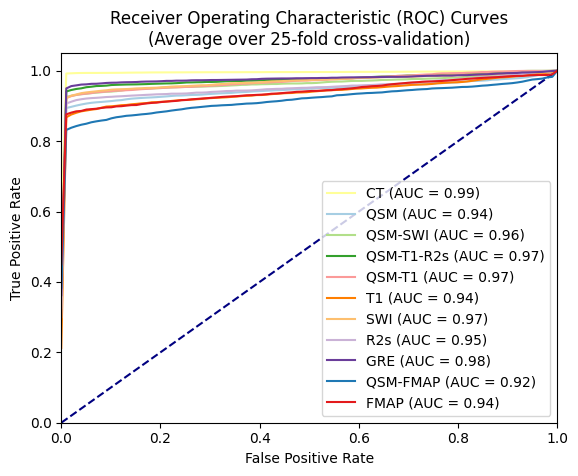

{'CT': [0.99, 0.04898979485566357], 'QSM': [0.8144761904761906, 0.18420377161843904], 'QSM-SWI': [0.8551428571428572, 0.17524544498044609], 'QSM-T1-R2s': [0.7953333333333333, 0.16941205519219832], 'QSM-T1': [0.8184761904761905, 0.19183122778799216], 'T1': [0.8733333333333333, 0.16686654681045104], 'SWI': [0.858952380952381, 0.18966407826743054], 'R2s': [0.8719999999999999, 0.18115186998758806], 'GRE': [0.8746666666666667, 0.1628987415543779], 'QSM-FMAP': [0.7518095238095238, 0.31160420269682176], 'FMAP': [0.84, 0.2817800560721074]}
{'CT': [1.0, 0.0], 'QSM': [0.92, 0.1423610433604175], 'QSM-SWI': [0.9466666666666668, 0.12220201853215575], 'QSM-T1-R2s': [0.9733333333333333, 0.09043106644167026], 'QSM-T1': [0.96, 0.10832051206181283], 'T1': [0.9333333333333332, 0.16329931618554522], 'SWI': [0.96, 0.10832051206181281], 'R2s': [0.9466666666666665, 0.12220201853215576], 'GRE': [0.9866666666666666, 0.06531972647421809], 'QSM-FMAP': [0.9333333333333332, 0.23094010767585033], 'FMAP': [0.8533333

In [9]:
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
model_marker_precisions = {}
model_marker_recalls = {}
losses = {}

for model in model_data.keys():#['CT']:
    print(f"=== {model} ===")

    df = pd.DataFrame(model_data[model])
    infile_cols = [key for key in list(model_data[model].keys()) if key != 'seg_files']
    n_input_channels = len(infile_cols)
    print(f"infile_cols: {infile_cols}; n_input_channels: {n_input_channels}")

    # determine resampling suggestion
    if model == 'CT':
        med_dataset = fastMONAI.vision_all.MedDataset(
            img_list=df.seg_files.tolist(),
            dtype=fastMONAI.vision_all.MedMask
        )
        suggested_voxelsize, requires_resampling = med_dataset.suggestion()
        largest_imagesize = med_dataset.get_largest_img_size(resample=suggested_voxelsize)

    # k validation folds
    kf = KFold(n_splits=k_folds, random_state=random_state, shuffle=True)

    marker_precisions = []
    marker_recalls = []
    precisions = []
    recalls = []
    fprs = []
    tprs = []
    fm_losses = []
    calc_losses = []


    for i, (train_index, valid_index) in enumerate(kf.split(df)):

        dblock = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter(valid_index),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )

        dls = fastMONAI.vision_all.DataLoaders.from_dblock(dblock, df, bs=batch_size)

        learn = fastMONAI.vision_all.Learner(
            dls,
            model=UNet(
                spatial_dims=3,
                in_channels=n_input_channels,
                out_channels=3,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2
            ),
            loss_func=DiceCELoss(
                to_onehot_y=True,
                include_background=True,
                softmax=True,
                weight=ce_loss_weights
            ),
            opt_func=fastMONAI.vision_all.ranger,
            metrics=[fastMONAI.vision_all.multi_dice_score, MarkersIdentified(), SuperfluousMarkers()]#.to_fp16()
        )

        model_file = glob.glob(f"models/{model}-2024*-*-{i}-best*")[0]
        print(model_file)
        learn = learn.load(model_file.replace("models/", "").replace(".pth", ""))

        if torch.cuda.is_available():
            learn.model.cuda()

        # Compute metrics on the entire dataset
        correct_markers = MarkersIdentified()

        dblock_valid_eval = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter([]),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize,
        )
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=1, sampler=fastMONAI.vision_all.SequentialSampler)
        for i, (x, y) in enumerate(dls_valid_eval.train):
            print(f"{i}/{len(dls_valid_eval.train)}", end="; ")
            pred = torch.argmax(learn.model(x), dim=1).unsqueeze(1).to(dtype=torch.float)
            correct_markers.accumulate(pred=pred.cpu(), targ=y.cpu())

        marker_tps = correct_markers.overlap_count
        marker_fps = correct_markers.pred_marker_count - correct_markers.overlap_count
        marker_fns = correct_markers.targ_marker_count - correct_markers.overlap_count

        marker_precision = (marker_tps / (marker_tps + marker_fps)) if (marker_tps + marker_fps) > 0 else 0
        marker_recall = (marker_tps / (marker_tps + marker_fns))  if (marker_tps + marker_fns) > 0 else 0
        marker_precisions.append(marker_precision)
        marker_recalls.append(marker_recall)

        loss, *metrics = learn.validate(ds_idx=0, dl=dls_valid_eval.train)
        fm_losses.append(metrics[0][0])
        calc_losses.append(metrics[0][1])

        print(f"Marker Precision: {marker_precision}")
        print(f"Marker Recall: {marker_recall}")
        print(f"Loss: {loss}")

        # get predictions
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=len(dls_valid_eval.train_ds), sampler=fastMONAI.vision_all.SequentialSampler)
        valid_x, valid_y = dls_valid_eval.train.one_batch()

        def calc_stuff(x, y):
            pred = learn.model(x)[:,1,:,:,:].unsqueeze(1).cpu().detach().numpy()
            pred -= np.min(pred)
            pred /= np.max(pred)
            pred = pred.flatten()
            targ = (y.cpu() == 1).to(dtype=torch.int).detach().numpy().flatten()

            # calculate AUC
            sample_weight = compute_sample_weight(class_weight="balanced", y=targ, indices=None)
            fpr, tpr, thresholds = roc_curve(targ, pred, sample_weight=sample_weight)
            roc_auc = auc(fpr, tpr)

            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(targ, pred)
            average_precision = average_precision_score(targ, pred)

            return fpr, tpr, precision, recall, thresholds, average_precision, roc_auc

        fpr, tpr, precision, recall, thresholds, average_tpr, roc_auc = calc_stuff(valid_x, valid_y)

        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        tprs.append(tpr)

    model_marker_precisions[model] = [np.mean(marker_precisions), np.std(marker_precisions)]
    model_marker_recalls[model] = [np.mean(marker_recalls), np.std(marker_recalls)]
    losses[model] = [np.mean(fm_losses), np.std(fm_losses), np.mean(calc_losses), np.std(calc_losses)]

    # define a common set of FPR values
    common_fpr = np.linspace(0, 1, 100)

    # initialize an empty array to hold the interpolated TPRs
    interpolated_tprs = []

    for tpr, fpr in zip(tprs, fprs):
        # interpolate the TPR values to the common FPR values
        interpolated_tpr = np.interp(common_fpr, fpr, tpr)
        
        # store the interpolated TPR
        interpolated_tprs.append(interpolated_tpr)

    # calculate the average TPR at each common FPR value
    average_tpr = np.mean(interpolated_tprs, axis=0)

    roc_auc = auc(common_fpr, average_tpr)

    # plot the average precision-recall curve
    plt.plot(common_fpr, average_tpr, color=colors[model], label=f'{model} (AUC = {round(roc_auc, 2)})')
    

    del learn, dls, dblock_valid_eval, dls_valid_eval, loss, metrics, valid_x, valid_y, correct_markers

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curves\n(Average over {k_folds}-fold cross-validation)')
plt.legend(loc="lower right")
plt.savefig("roc-curves-new3.png", dpi=400)
plt.show()

print(model_marker_precisions)
print(model_marker_recalls)
print(losses)

=== CT ===
infile_cols: ['ct_files']; n_input_channels: 1
models/CT-20240322-162023-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.10499604791402817
models/CT-20240322-162023-1-best.pth


Saved file doesn't contain an optimizer state.


1/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36206719279289246
models/CT-20240322-162018-2-best.pth


Saved file doesn't contain an optimizer state.


2/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.08980979770421982
models/CT-20240322-165315-3-best.pth


Saved file doesn't contain an optimizer state.


3/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.15072788298130035
models/CT-20240322-165714-4-best.pth


Saved file doesn't contain an optimizer state.


4/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.07807963341474533
models/CT-20240322-170940-5-best.pth


Saved file doesn't contain an optimizer state.


5/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3709924519062042
models/CT-20240322-171829-6-best.pth


Saved file doesn't contain an optimizer state.


6/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.12206979095935822
models/CT-20240322-173639-7-best.pth


Saved file doesn't contain an optimizer state.


7/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3592906892299652
models/CT-20240322-173915-8-best.pth


Saved file doesn't contain an optimizer state.


8/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.08902488648891449
models/CT-20240322-180519-9-best.pth


Saved file doesn't contain an optimizer state.


9/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.07233326137065887
models/CT-20240322-180653-10-best.pth


Saved file doesn't contain an optimizer state.


10/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.06723795086145401
models/CT-20240322-182026-11-best.pth


Saved file doesn't contain an optimizer state.


11/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.07716207206249237
models/CT-20240322-184239-12-best.pth


Saved file doesn't contain an optimizer state.


12/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.08638177812099457
models/CT-20240322-185503-13-best.pth


Saved file doesn't contain an optimizer state.


13/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.0640205517411232
models/CT-20240322-185839-14-best.pth


Saved file doesn't contain an optimizer state.


14/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3923892080783844
models/CT-20240322-191102-15-best.pth


Saved file doesn't contain an optimizer state.


15/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.06838838756084442
models/CT-20240322-192536-16-best.pth


Saved file doesn't contain an optimizer state.


16/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37533119320869446
models/CT-20240322-192946-17-best.pth


Saved file doesn't contain an optimizer state.


17/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.05212792009115219
models/CT-20240322-195319-18-best.pth


Saved file doesn't contain an optimizer state.


18/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.0719078779220581
models/CT-20240322-200204-19-best.pth


Saved file doesn't contain an optimizer state.


19/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.06564923375844955
models/CT-20240322-200440-20-best.pth


Saved file doesn't contain an optimizer state.


20/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36085474491119385
models/CT-20240322-202141-21-best.pth


Saved file doesn't contain an optimizer state.


21/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36809617280960083
models/CT-20240322-202836-22-best.pth


Saved file doesn't contain an optimizer state.


22/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.09370841085910797
models/CT-20240322-203823-23-best.pth


Saved file doesn't contain an optimizer state.


23/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36261579394340515
models/CT-20240322-204912-24-best.pth


Saved file doesn't contain an optimizer state.


24/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.1646495908498764
=== QSM ===
infile_cols: ['qsm_files']; n_input_channels: 1
models/QSM-20240404-193410-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.42804497480392456
models/QSM-20240404-194613-1-best.pth


Saved file doesn't contain an optimizer state.


1/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4440886080265045
models/QSM-20240404-200251-2-best.pth


Saved file doesn't contain an optimizer state.


2/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.24963080883026123
models/QSM-20240404-200938-3-best.pth


Saved file doesn't contain an optimizer state.


3/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.25985538959503174
models/QSM-20240404-203013-4-best.pth


Saved file doesn't contain an optimizer state.


4/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.4991804361343384
models/QSM-20240404-205511-5-best.pth


Saved file doesn't contain an optimizer state.


5/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3669114410877228
models/QSM-20240404-210427-6-best.pth


Saved file doesn't contain an optimizer state.


6/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38169750571250916
models/QSM-20240404-210934-7-best.pth


Saved file doesn't contain an optimizer state.


7/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.38959017395973206
models/QSM-20240404-212652-8-best.pth


Saved file doesn't contain an optimizer state.


8/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.42576444149017334
models/QSM-20240404-213045-9-best.pth


Saved file doesn't contain an optimizer state.


9/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.41573017835617065
models/QSM-20240404-213957-10-best.pth


Saved file doesn't contain an optimizer state.


10/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3934234380722046
models/QSM-20240404-215412-11-best.pth


Saved file doesn't contain an optimizer state.


11/1; 

Marker Precision: 0.42857142857142855
Marker Recall: 1.0
Loss: 0.4491422176361084
models/QSM-20240404-220858-12-best.pth


Saved file doesn't contain an optimizer state.


12/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3977896273136139
models/QSM-20240404-222050-13-best.pth


Saved file doesn't contain an optimizer state.


13/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3980303108692169
models/QSM-20240404-222514-14-best.pth


Saved file doesn't contain an optimizer state.


14/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 0.6666666666666666
Loss: 0.5474432706832886
models/QSM-20240404-223854-15-best.pth


Saved file doesn't contain an optimizer state.


15/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.43464747071266174
models/QSM-20240404-230110-16-best.pth


Saved file doesn't contain an optimizer state.


16/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3812362849712372
models/QSM-20240404-230748-17-best.pth


Saved file doesn't contain an optimizer state.


17/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.24551978707313538
models/QSM-20240404-232826-18-best.pth


Saved file doesn't contain an optimizer state.


18/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4199259579181671
models/QSM-20240404-232052-19-best.pth


Saved file doesn't contain an optimizer state.


19/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.23455515503883362
models/QSM-20240404-234457-20-best.pth


Saved file doesn't contain an optimizer state.


20/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4373331069946289
models/QSM-20240405-000418-21-best.pth


Saved file doesn't contain an optimizer state.


21/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4456283152103424
models/QSM-20240405-001415-22-best.pth


Saved file doesn't contain an optimizer state.


22/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.44248729944229126
models/QSM-20240405-002415-23-best.pth


Saved file doesn't contain an optimizer state.


23/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3810592293739319
models/QSM-20240405-004158-24-best.pth


Saved file doesn't contain an optimizer state.


24/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.5237764120101929
=== QSM-SWI ===
infile_cols: ['qsm_files', 'swi_files']; n_input_channels: 2
models/QSM-SWI-20240406-093356-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3593864142894745
models/QSM-SWI-20240406-095930-1-best.pth


Saved file doesn't contain an optimizer state.


1/1; 

Mean of empty slice


Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.4475332200527191
models/QSM-SWI-20240406-100728-2-best.pth


Saved file doesn't contain an optimizer state.


2/1; 

Marker Precision: 0.42857142857142855
Marker Recall: 1.0
Loss: 0.3335060179233551
models/QSM-SWI-20240406-102932-3-best.pth


Saved file doesn't contain an optimizer state.


3/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.2659934163093567
models/QSM-SWI-20240406-103401-4-best.pth


Saved file doesn't contain an optimizer state.


4/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.5098098516464233
models/QSM-SWI-20240406-105425-5-best.pth


Saved file doesn't contain an optimizer state.


5/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36222100257873535
models/QSM-SWI-20240406-110158-6-best.pth


Saved file doesn't contain an optimizer state.


6/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3810230493545532
models/QSM-SWI-20240406-111532-7-best.pth


Saved file doesn't contain an optimizer state.


7/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.39222195744514465
models/QSM-SWI-20240406-113254-8-best.pth


Saved file doesn't contain an optimizer state.


8/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4149378836154938
models/QSM-SWI-20240406-113404-9-best.pth


Saved file doesn't contain an optimizer state.


9/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.43521615862846375
models/QSM-SWI-20240406-114726-10-best.pth


Saved file doesn't contain an optimizer state.


10/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.39042818546295166
models/QSM-SWI-20240406-122406-11-best.pth


Saved file doesn't contain an optimizer state.


11/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4404771327972412
models/QSM-SWI-20240406-122504-12-best.pth


Saved file doesn't contain an optimizer state.


12/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3754156827926636
models/QSM-SWI-20240406-123810-13-best.pth


Saved file doesn't contain an optimizer state.


13/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.41649165749549866
models/QSM-SWI-20240406-125823-14-best.pth


Saved file doesn't contain an optimizer state.


14/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.39422306418418884
models/QSM-SWI-20240406-131143-15-best.pth


Saved file doesn't contain an optimizer state.


15/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.46372392773628235
models/QSM-SWI-20240406-132153-16-best.pth


Saved file doesn't contain an optimizer state.


16/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3881166875362396
models/QSM-SWI-20240406-133942-17-best.pth


Saved file doesn't contain an optimizer state.


17/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.23218858242034912
models/QSM-SWI-20240406-134917-18-best.pth


Saved file doesn't contain an optimizer state.


18/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3261964023113251
models/QSM-SWI-20240406-140840-19-best.pth


Saved file doesn't contain an optimizer state.


19/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.228903666138649
models/QSM-SWI-20240406-144138-20-best.pth


Saved file doesn't contain an optimizer state.


20/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4469135105609894
models/QSM-SWI-20240406-144648-21-best.pth


Saved file doesn't contain an optimizer state.


21/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.42673879861831665
models/QSM-SWI-20240406-151524-22-best.pth


Saved file doesn't contain an optimizer state.


22/1; 

Mean of empty slice


Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.42796289920806885
models/QSM-SWI-20240406-151914-23-best.pth


Saved file doesn't contain an optimizer state.


23/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38414469361305237
models/QSM-SWI-20240406-151946-24-best.pth


Saved file doesn't contain an optimizer state.


24/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.494202584028244
=== QSM-T1-R2s ===
infile_cols: ['qsm_files', 't1_files', 'r2s_files']; n_input_channels: 3
models/QSM-T1-R2s-20240405-200745-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4158603549003601
models/QSM-T1-R2s-20240405-203754-1-best.pth


Saved file doesn't contain an optimizer state.


1/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4170023500919342
models/QSM-T1-R2s-20240405-204000-2-best.pth


Saved file doesn't contain an optimizer state.


2/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.31187084317207336
models/QSM-T1-R2s-20240405-204920-3-best.pth


Saved file doesn't contain an optimizer state.


3/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.37844446301460266
models/QSM-T1-R2s-20240405-212344-4-best.pth


Saved file doesn't contain an optimizer state.


4/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.45097121596336365
models/QSM-T1-R2s-20240405-212905-5-best.pth


Saved file doesn't contain an optimizer state.


5/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3629022538661957
models/QSM-T1-R2s-20240405-213415-6-best.pth


Saved file doesn't contain an optimizer state.


6/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3783091902732849
models/QSM-T1-R2s-20240405-221145-7-best.pth


Saved file doesn't contain an optimizer state.


7/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.39756888151168823
models/QSM-T1-R2s-20240405-223423-8-best.pth


Saved file doesn't contain an optimizer state.


8/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4219556152820587
models/QSM-T1-R2s-20240405-223429-9-best.pth


Saved file doesn't contain an optimizer state.


9/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.3016095459461212
models/QSM-T1-R2s-20240405-230532-10-best.pth


Saved file doesn't contain an optimizer state.


10/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38419172167778015
models/QSM-T1-R2s-20240405-230817-11-best.pth


Saved file doesn't contain an optimizer state.


11/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4285128712654114
models/QSM-T1-R2s-20240405-234202-12-best.pth


Saved file doesn't contain an optimizer state.


12/1; 

Mean of empty slice


Marker Precision: 0.6666666666666666
Marker Recall: 1.0
Loss: 0.3655910789966583
models/QSM-T1-R2s-20240405-234653-13-best.pth


Saved file doesn't contain an optimizer state.


13/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.43756604194641113
models/QSM-T1-R2s-20240405-235155-14-best.pth


Saved file doesn't contain an optimizer state.


14/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3969045579433441
models/QSM-T1-R2s-20240406-002523-15-best.pth


Saved file doesn't contain an optimizer state.


15/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.40015020966529846
models/QSM-T1-R2s-20240406-002903-16-best.pth


Saved file doesn't contain an optimizer state.


16/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38567644357681274
models/QSM-T1-R2s-20240406-005627-17-best.pth


Saved file doesn't contain an optimizer state.


17/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.34239327907562256
models/QSM-T1-R2s-20240406-011451-18-best.pth


Saved file doesn't contain an optimizer state.


18/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.29427286982536316
models/QSM-T1-R2s-20240406-012254-19-best.pth


Saved file doesn't contain an optimizer state.


19/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.29928648471832275
models/QSM-T1-R2s-20240406-020730-20-best.pth


Saved file doesn't contain an optimizer state.


20/1; 

Mean of empty slice


Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4312940537929535
models/QSM-T1-R2s-20240406-021336-21-best.pth


Saved file doesn't contain an optimizer state.


21/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4196501076221466
models/QSM-T1-R2s-20240406-024527-22-best.pth


Saved file doesn't contain an optimizer state.


22/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.43275558948516846
models/QSM-T1-R2s-20240406-030111-23-best.pth


Saved file doesn't contain an optimizer state.


23/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.40056130290031433
models/QSM-T1-R2s-20240406-030947-24-best.pth


Saved file doesn't contain an optimizer state.


24/1; 

Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.4516257047653198
=== QSM-T1 ===
infile_cols: ['qsm_files', 't1_files']; n_input_channels: 2
models/QSM-T1-20240406-033809-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3675072491168976
models/QSM-T1-20240406-034536-1-best.pth


Saved file doesn't contain an optimizer state.


1/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.44987204670906067
models/QSM-T1-20240406-035411-2-best.pth


Saved file doesn't contain an optimizer state.


2/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.2753935158252716
models/QSM-T1-20240406-042853-3-best.pth


Saved file doesn't contain an optimizer state.


3/1; 

Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.27270299196243286
models/QSM-T1-20240406-043913-4-best.pth


Saved file doesn't contain an optimizer state.


4/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.43342697620391846
models/QSM-T1-20240406-044559-5-best.pth


Saved file doesn't contain an optimizer state.


5/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37916189432144165
models/QSM-T1-20240406-051159-6-best.pth


Saved file doesn't contain an optimizer state.


6/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.40364810824394226
models/QSM-T1-20240406-051834-7-best.pth


Saved file doesn't contain an optimizer state.


7/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37085026502609253
models/QSM-T1-20240406-053243-8-best.pth


Saved file doesn't contain an optimizer state.


8/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4033682346343994
models/QSM-T1-20240406-055223-9-best.pth


Saved file doesn't contain an optimizer state.


9/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.38666242361068726
models/QSM-T1-20240406-055656-10-best.pth


Saved file doesn't contain an optimizer state.


10/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3946409523487091
models/QSM-T1-20240406-061317-11-best.pth


Saved file doesn't contain an optimizer state.


11/1; 

Marker Precision: 0.42857142857142855
Marker Recall: 1.0
Loss: 0.4389787018299103
models/QSM-T1-20240406-063223-12-best.pth


Saved file doesn't contain an optimizer state.


12/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.385491281747818
models/QSM-T1-20240406-065135-13-best.pth


Saved file doesn't contain an optimizer state.


13/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4196869432926178
models/QSM-T1-20240406-065409-14-best.pth


Saved file doesn't contain an optimizer state.


14/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.45858561992645264
models/QSM-T1-20240406-072522-15-best.pth


Saved file doesn't contain an optimizer state.


15/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4070708453655243
models/QSM-T1-20240406-073048-16-best.pth


Saved file doesn't contain an optimizer state.


16/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37891581654548645
models/QSM-T1-20240406-073346-17-best.pth


Saved file doesn't contain an optimizer state.


17/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.32815152406692505
models/QSM-T1-20240406-080913-18-best.pth


Saved file doesn't contain an optimizer state.


18/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3668460249900818
models/QSM-T1-20240406-081928-19-best.pth


Saved file doesn't contain an optimizer state.


19/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.31760016083717346
models/QSM-T1-20240406-082403-20-best.pth


Saved file doesn't contain an optimizer state.


20/1; 

Mean of empty slice


Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4333619177341461
models/QSM-T1-20240406-085215-21-best.pth


Saved file doesn't contain an optimizer state.


21/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4306814670562744
models/QSM-T1-20240406-085727-22-best.pth


Saved file doesn't contain an optimizer state.


22/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.4110432267189026
models/QSM-T1-20240406-092357-23-best.pth


Saved file doesn't contain an optimizer state.


23/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.39801082015037537
models/QSM-T1-20240406-092531-24-best.pth


Saved file doesn't contain an optimizer state.


24/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.48703163862228394
=== T1 ===
infile_cols: ['t1_files']; n_input_channels: 1
models/T1-20240405-055604-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4547758996486664
models/T1-20240405-061633-1-best.pth


Saved file doesn't contain an optimizer state.


1/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4053078293800354
models/T1-20240405-061705-2-best.pth


Saved file doesn't contain an optimizer state.


2/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.43641525506973267
models/T1-20240405-062011-3-best.pth


Saved file doesn't contain an optimizer state.


3/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.39077505469322205
models/T1-20240405-063921-4-best.pth


Saved file doesn't contain an optimizer state.


4/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.43378737568855286
models/T1-20240405-065147-5-best.pth


Saved file doesn't contain an optimizer state.


5/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4076329469680786
models/T1-20240405-070744-6-best.pth


Saved file doesn't contain an optimizer state.


6/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.45975950360298157
models/T1-20240405-071429-7-best.pth


Saved file doesn't contain an optimizer state.


7/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4778110682964325
models/T1-20240405-072608-8-best.pth


Saved file doesn't contain an optimizer state.


8/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.40572014451026917
models/T1-20240405-073307-9-best.pth


Saved file doesn't contain an optimizer state.


9/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.461234986782074
models/T1-20240405-074007-10-best.pth


Saved file doesn't contain an optimizer state.


10/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4145801067352295
models/T1-20240405-075744-11-best.pth


Saved file doesn't contain an optimizer state.


11/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.42202091217041016
models/T1-20240405-080429-12-best.pth


Saved file doesn't contain an optimizer state.


12/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3823494613170624
models/T1-20240405-080940-13-best.pth


Saved file doesn't contain an optimizer state.


13/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.4658230245113373
models/T1-20240405-083321-14-best.pth


Saved file doesn't contain an optimizer state.


14/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.5156318545341492
models/T1-20240405-083900-15-best.pth


Saved file doesn't contain an optimizer state.


15/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.41157397627830505
models/T1-20240405-083930-16-best.pth


Saved file doesn't contain an optimizer state.


16/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3965018689632416
models/T1-20240405-085521-17-best.pth


Saved file doesn't contain an optimizer state.


17/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.45835286378860474
models/T1-20240405-090535-18-best.pth


Saved file doesn't contain an optimizer state.


18/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.34903666377067566
models/T1-20240405-091245-19-best.pth


Saved file doesn't contain an optimizer state.


19/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.5041745901107788
models/T1-20240405-093628-20-best.pth


Saved file doesn't contain an optimizer state.


20/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.3333333333333333
Loss: 0.5328027009963989
models/T1-20240405-093701-21-best.pth


Saved file doesn't contain an optimizer state.


21/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4671086370944977
models/T1-20240405-095843-22-best.pth


Saved file doesn't contain an optimizer state.


22/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.4320843517780304
models/T1-20240405-095914-23-best.pth


Saved file doesn't contain an optimizer state.


23/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.40892094373703003
models/T1-20240405-100332-24-best.pth


Saved file doesn't contain an optimizer state.


24/1; 

Marker Precision: 0.5
Marker Recall: 0.6666666666666666
Loss: 0.48076730966567993
=== SWI ===
infile_cols: ['swi_files']; n_input_channels: 1
models/SWI-20240405-004402-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.30215394496917725
models/SWI-20240405-005911-1-best.pth


Saved file doesn't contain an optimizer state.


1/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4147748649120331
models/SWI-20240405-011700-2-best.pth


Saved file doesn't contain an optimizer state.


2/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.36716702580451965
models/SWI-20240405-012409-3-best.pth


Saved file doesn't contain an optimizer state.


3/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.32661908864974976
models/SWI-20240405-013437-4-best.pth


Saved file doesn't contain an optimizer state.


4/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.48074689507484436
models/SWI-20240405-020338-5-best.pth


Saved file doesn't contain an optimizer state.


5/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3779882490634918
models/SWI-20240405-020509-6-best.pth


Saved file doesn't contain an optimizer state.


6/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3774286210536957
models/SWI-20240405-020941-7-best.pth


Saved file doesn't contain an optimizer state.


7/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.40477311611175537
models/SWI-20240405-024031-8-best.pth


Saved file doesn't contain an optimizer state.


8/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4131861627101898
models/SWI-20240405-024057-9-best.pth


Saved file doesn't contain an optimizer state.


9/1; 

Marker Precision: 0.42857142857142855
Marker Recall: 1.0
Loss: 0.5103451609611511
models/SWI-20240405-024800-10-best.pth


Saved file doesn't contain an optimizer state.


10/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3987560272216797
models/SWI-20240405-031138-11-best.pth


Saved file doesn't contain an optimizer state.


11/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.309420645236969
models/SWI-20240405-031341-12-best.pth


Saved file doesn't contain an optimizer state.


12/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3764437139034271
models/SWI-20240405-032309-13-best.pth


Saved file doesn't contain an optimizer state.


13/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.44446316361427307
models/SWI-20240405-035103-14-best.pth


Saved file doesn't contain an optimizer state.


14/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38089150190353394
models/SWI-20240405-035238-15-best.pth


Saved file doesn't contain an optimizer state.


15/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.5602633953094482
models/SWI-20240405-035440-16-best.pth


Saved file doesn't contain an optimizer state.


16/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3855130076408386
models/SWI-20240405-041707-17-best.pth


Saved file doesn't contain an optimizer state.


17/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4417564570903778
models/SWI-20240405-042355-18-best.pth


Saved file doesn't contain an optimizer state.


18/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3603796064853668
models/SWI-20240405-044317-19-best.pth


Saved file doesn't contain an optimizer state.


19/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3078879117965698
models/SWI-20240405-044418-20-best.pth


Saved file doesn't contain an optimizer state.


20/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.49224916100502014
models/SWI-20240405-050657-21-best.pth


Saved file doesn't contain an optimizer state.


21/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4318501949310303
models/SWI-20240405-053107-22-best.pth


Saved file doesn't contain an optimizer state.


22/1; 

Mean of empty slice


Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.41848742961883545
models/SWI-20240405-053315-23-best.pth


Saved file doesn't contain an optimizer state.


23/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38296499848365784
models/SWI-20240405-053753-24-best.pth


Saved file doesn't contain an optimizer state.


24/1; 

Marker Precision: 0.42857142857142855
Marker Recall: 1.0
Loss: 0.5510965585708618
=== R2s ===
infile_cols: ['r2s_files']; n_input_channels: 1
models/R2s-20240405-102401-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.44013774394989014
models/R2s-20240405-102609-1-best.pth


Saved file doesn't contain an optimizer state.


1/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3887235224246979
models/R2s-20240405-102741-2-best.pth


Saved file doesn't contain an optimizer state.


2/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4149327278137207
models/R2s-20240405-104734-3-best.pth


Saved file doesn't contain an optimizer state.


3/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3786090612411499
models/R2s-20240405-105809-4-best.pth


Saved file doesn't contain an optimizer state.


4/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4167807102203369
models/R2s-20240405-110247-5-best.pth


Saved file doesn't contain an optimizer state.


5/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36538219451904297
models/R2s-20240405-111110-6-best.pth


Saved file doesn't contain an optimizer state.


6/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3791586458683014
models/R2s-20240405-113841-7-best.pth


Saved file doesn't contain an optimizer state.


7/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.48989570140838623
models/R2s-20240405-114509-8-best.pth


Saved file doesn't contain an optimizer state.


8/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.41628530621528625
models/R2s-20240405-115449-9-best.pth


Saved file doesn't contain an optimizer state.


9/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.35261043906211853
models/R2s-20240405-121019-10-best.pth


Saved file doesn't contain an optimizer state.


10/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.43610507249832153
models/R2s-20240405-121503-11-best.pth


Saved file doesn't contain an optimizer state.


11/1; 

Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.4079292118549347
models/R2s-20240405-124319-12-best.pth


Saved file doesn't contain an optimizer state.


12/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3809143900871277
models/R2s-20240405-125109-13-best.pth


Saved file doesn't contain an optimizer state.


13/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.43406033515930176
models/R2s-20240405-125214-14-best.pth


Saved file doesn't contain an optimizer state.


14/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3742201328277588
models/R2s-20240405-131653-15-best.pth


Saved file doesn't contain an optimizer state.


15/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4517262578010559
models/R2s-20240405-132217-16-best.pth


Saved file doesn't contain an optimizer state.


16/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3883105218410492
models/R2s-20240405-132850-17-best.pth


Saved file doesn't contain an optimizer state.


17/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4476812779903412
models/R2s-20240405-135200-18-best.pth


Saved file doesn't contain an optimizer state.


18/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4097639322280884
models/R2s-20240405-135225-19-best.pth


Saved file doesn't contain an optimizer state.


19/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.46171072125434875
models/R2s-20240405-141523-20-best.pth


Saved file doesn't contain an optimizer state.


20/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4801357686519623
models/R2s-20240405-141839-21-best.pth


Saved file doesn't contain an optimizer state.


21/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4651688039302826
models/R2s-20240405-142751-22-best.pth


Saved file doesn't contain an optimizer state.


22/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4270736277103424
models/R2s-20240405-144336-23-best.pth


Saved file doesn't contain an optimizer state.


23/1; 

Mean of empty slice


Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4186677932739258
models/R2s-20240405-144612-24-best.pth


Saved file doesn't contain an optimizer state.


24/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4323985278606415
=== GRE ===
infile_cols: ['mag_files']; n_input_channels: 1
models/GRE-20240405-150239-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3170015811920166
models/GRE-20240405-152126-1-best.pth


Saved file doesn't contain an optimizer state.


1/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3876318037509918
models/GRE-20240405-152603-2-best.pth


Saved file doesn't contain an optimizer state.


2/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.23449432849884033
models/GRE-20240405-155600-3-best.pth


Saved file doesn't contain an optimizer state.


3/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3719189465045929
models/GRE-20240405-160131-4-best.pth


Saved file doesn't contain an optimizer state.


4/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.47698503732681274
models/GRE-20240405-161318-5-best.pth


Saved file doesn't contain an optimizer state.


5/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3711691200733185
models/GRE-20240405-162042-6-best.pth


Saved file doesn't contain an optimizer state.


6/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3781405985355377
models/GRE-20240405-162519-7-best.pth


Saved file doesn't contain an optimizer state.


7/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.41183504462242126
models/GRE-20240405-165158-8-best.pth


Saved file doesn't contain an optimizer state.


8/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4284605085849762
models/GRE-20240405-165717-9-best.pth


Saved file doesn't contain an optimizer state.


9/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4247931241989136
models/GRE-20240405-170438-10-best.pth


Saved file doesn't contain an optimizer state.


10/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4029531478881836
models/GRE-20240405-172234-11-best.pth


Saved file doesn't contain an optimizer state.


11/1; 

Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.42977848649024963
models/GRE-20240405-172453-12-best.pth


Saved file doesn't contain an optimizer state.


12/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36201903223991394
models/GRE-20240405-174413-13-best.pth


Saved file doesn't contain an optimizer state.


13/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.40286797285079956
models/GRE-20240405-175552-14-best.pth


Saved file doesn't contain an optimizer state.


14/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3745788037776947
models/GRE-20240405-180616-15-best.pth


Saved file doesn't contain an optimizer state.


15/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.42157483100891113
models/GRE-20240405-182831-16-best.pth


Saved file doesn't contain an optimizer state.


16/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.38069948554039
models/GRE-20240405-183038-17-best.pth


Saved file doesn't contain an optimizer state.


17/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3675994575023651
models/GRE-20240405-184637-18-best.pth


Saved file doesn't contain an optimizer state.


18/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3925870954990387
models/GRE-20240405-190121-19-best.pth


Saved file doesn't contain an optimizer state.


19/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.2421833872795105
models/GRE-20240405-190841-20-best.pth


Saved file doesn't contain an optimizer state.


20/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4473779499530792
models/GRE-20240405-192929-21-best.pth


Saved file doesn't contain an optimizer state.


21/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.42178866267204285
models/GRE-20240405-193715-22-best.pth


Saved file doesn't contain an optimizer state.


22/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4048922657966614
models/GRE-20240405-195503-23-best.pth


Saved file doesn't contain an optimizer state.


23/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.36601442098617554
models/GRE-20240405-200013-24-best.pth


Saved file doesn't contain an optimizer state.


24/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.4536854326725006
=== QSM-FMAP ===
infile_cols: ['qsm_files', 'fmap_files']; n_input_channels: 2
models/QSM-FMAP-20240404-132733-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.0
Marker Recall: 0.0
Loss: 0.672701358795166
models/QSM-FMAP-20240404-131545-1-best.pth


Saved file doesn't contain an optimizer state.


1/1; 

Mean of empty slice


Marker Precision: 0.047619047619047616
Marker Recall: 1.3333333333333333
Loss: 1.4710766077041626
models/QSM-FMAP-20240404-131545-2-best.pth


Saved file doesn't contain an optimizer state.


2/1; 

Marker Precision: 0.046875
Marker Recall: 1.0
Loss: 1.9421213865280151
models/QSM-FMAP-20240404-135657-3-best.pth


Saved file doesn't contain an optimizer state.


3/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.26983338594436646
models/QSM-FMAP-20240404-140913-4-best.pth


Saved file doesn't contain an optimizer state.


4/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.4994267225265503
models/QSM-FMAP-20240404-141231-5-best.pth


Saved file doesn't contain an optimizer state.


5/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3603077232837677
models/QSM-FMAP-20240404-144833-6-best.pth


Saved file doesn't contain an optimizer state.


6/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3651822805404663
models/QSM-FMAP-20240404-145831-7-best.pth


Saved file doesn't contain an optimizer state.


7/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3729409873485565
models/QSM-FMAP-20240404-150532-8-best.pth


Saved file doesn't contain an optimizer state.


8/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4242367148399353
models/QSM-FMAP-20240404-152928-9-best.pth


Saved file doesn't contain an optimizer state.


9/1; 

Marker Precision: 0.6666666666666666
Marker Recall: 0.6666666666666666
Loss: 0.5758954286575317
models/QSM-FMAP-20240404-153739-10-best.pth


Saved file doesn't contain an optimizer state.


10/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36534127593040466
models/QSM-FMAP-20240404-155322-11-best.pth


Saved file doesn't contain an optimizer state.


11/1; 

Marker Precision: 0.6
Marker Recall: 1.0
Loss: 0.41540423035621643
models/QSM-FMAP-20240404-160448-12-best.pth


Saved file doesn't contain an optimizer state.


12/1; 

Mean of empty slice


Marker Precision: 0.6666666666666666
Marker Recall: 1.0
Loss: 0.35833507776260376
models/QSM-FMAP-20240404-162708-13-best.pth


Saved file doesn't contain an optimizer state.


13/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3952736258506775
models/QSM-FMAP-20240404-163411-14-best.pth


Saved file doesn't contain an optimizer state.


14/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.377423495054245
models/QSM-FMAP-20240404-164430-15-best.pth


Saved file doesn't contain an optimizer state.


15/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4186668395996094
models/QSM-FMAP-20240404-171524-16-best.pth


Saved file doesn't contain an optimizer state.


16/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.37351155281066895
models/QSM-FMAP-20240404-171720-17-best.pth


Saved file doesn't contain an optimizer state.


17/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.16799253225326538
models/QSM-FMAP-20240404-172147-18-best.pth


Saved file doesn't contain an optimizer state.


18/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.311290979385376
models/QSM-FMAP-20240404-174804-19-best.pth


Saved file doesn't contain an optimizer state.


19/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.26428622007369995
models/QSM-FMAP-20240404-181624-20-best.pth


Saved file doesn't contain an optimizer state.


20/1; 

Mean of empty slice


Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.42608126997947693
models/QSM-FMAP-20240404-182941-21-best.pth


Saved file doesn't contain an optimizer state.


21/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.4220888316631317
models/QSM-FMAP-20240404-183736-22-best.pth


Saved file doesn't contain an optimizer state.


22/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.371462345123291
models/QSM-FMAP-20240404-190924-23-best.pth


Saved file doesn't contain an optimizer state.


23/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3572908341884613
models/QSM-FMAP-20240404-191023-24-best.pth


Saved file doesn't contain an optimizer state.


24/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.464252769947052
=== FMAP ===
infile_cols: ['fmap_files']; n_input_channels: 1
models/FMAP-20240408-094032-0-best.pth


Saved file doesn't contain an optimizer state.


0/1; 

Marker Precision: 0.0
Marker Recall: 0.0
Loss: 0.6712831854820251
models/FMAP-20240408-094032-1-best.pth


Saved file doesn't contain an optimizer state.


1/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3788880705833435
models/FMAP-20240408-094032-2-best.pth


Saved file doesn't contain an optimizer state.


2/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3702567517757416
models/FMAP-20240408-095850-3-best.pth


Saved file doesn't contain an optimizer state.


3/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.35896575450897217
models/FMAP-20240408-101622-4-best.pth


Saved file doesn't contain an optimizer state.


4/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.46587613224983215
models/FMAP-20240408-101923-5-best.pth


Saved file doesn't contain an optimizer state.


5/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3798704743385315
models/FMAP-20240408-102523-6-best.pth


Saved file doesn't contain an optimizer state.


6/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3706965744495392
models/FMAP-20240408-105052-7-best.pth


Saved file doesn't contain an optimizer state.


7/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3625822365283966
models/FMAP-20240408-105147-8-best.pth


Saved file doesn't contain an optimizer state.


8/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.4171574115753174
models/FMAP-20240408-105544-9-best.pth


Saved file doesn't contain an optimizer state.


9/1; 

Marker Precision: 0.0
Marker Recall: 0.0
Loss: 0.6688717603683472
models/FMAP-20240408-111631-10-best.pth


Saved file doesn't contain an optimizer state.


10/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3754452168941498
models/FMAP-20240408-112540-11-best.pth


Saved file doesn't contain an optimizer state.


11/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3905688524246216
models/FMAP-20240408-114226-12-best.pth


Saved file doesn't contain an optimizer state.


12/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3648854196071625
models/FMAP-20240408-120654-13-best.pth


Saved file doesn't contain an optimizer state.


13/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4209708571434021
models/FMAP-20240408-115620-14-best.pth


Saved file doesn't contain an optimizer state.


14/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36347681283950806
models/FMAP-20240408-121459-15-best.pth


Saved file doesn't contain an optimizer state.


15/1; 

Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.42711547017097473
models/FMAP-20240408-121948-16-best.pth


Saved file doesn't contain an optimizer state.


16/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.3673613667488098
models/FMAP-20240408-123955-17-best.pth


Saved file doesn't contain an optimizer state.


17/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.2057420015335083
models/FMAP-20240408-124149-18-best.pth


Saved file doesn't contain an optimizer state.


18/1; 

Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.34298497438430786
models/FMAP-20240408-124809-19-best.pth


Saved file doesn't contain an optimizer state.


19/1; 

Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.31652072072029114
models/FMAP-20240408-132853-20-best.pth


Saved file doesn't contain an optimizer state.


20/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4254736006259918
models/FMAP-20240408-132909-21-best.pth


Saved file doesn't contain an optimizer state.


21/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 0.6666666666666666
Loss: 0.4579951763153076
models/FMAP-20240408-133754-22-best.pth


Saved file doesn't contain an optimizer state.


22/1; 

Mean of empty slice


Marker Precision: 1.0
Marker Recall: 1.0
Loss: 0.36785897612571716
models/FMAP-20240408-135713-23-best.pth


Saved file doesn't contain an optimizer state.


23/1; 

Mean of empty slice


Marker Precision: 0.75
Marker Recall: 1.0
Loss: 0.3701184391975403
models/FMAP-20240408-140824-24-best.pth


Saved file doesn't contain an optimizer state.


24/1; 

Marker Precision: 0.5
Marker Recall: 1.0
Loss: 0.443622350692749
{'CT': [0.99, 0.04898979485566357], 'QSM': [0.8144761904761906, 0.18420377161843904], 'QSM-SWI': [0.8551428571428572, 0.17524544498044609], 'QSM-T1-R2s': [0.7953333333333333, 0.16941205519219832], 'QSM-T1': [0.8184761904761905, 0.19183122778799216], 'T1': [0.8733333333333333, 0.16686654681045104], 'SWI': [0.858952380952381, 0.18966407826743054], 'R2s': [0.8719999999999999, 0.18115186998758806], 'GRE': [0.8746666666666667, 0.1628987415543779], 'QSM-FMAP': [0.7517797619047619, 0.3116714881034174], 'FMAP': [0.84, 0.2817800560721074]}
{'CT': [1.0, 0.0], 'QSM': [0.92, 0.1423610433604175], 'QSM-SWI': [0.9466666666666668, 0.12220201853215575], 'QSM-T1-R2s': [0.9733333333333333, 0.09043106644167026], 'QSM-T1': [0.96, 0.10832051206181283], 'T1': [0.9333333333333332, 0.16329931618554522], 'SWI': [0.96, 0.10832051206181281], 'R2s': [0.9466666666666665, 0.12220201853215576], 'GRE': [0.9866666666666666, 0.06531972647421809], 'QSM-FMAP

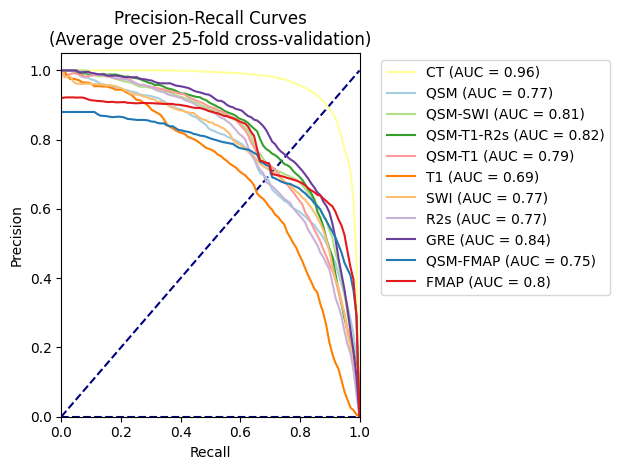

In [10]:
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

total_samples = 0
positive_samples = 0

model_marker_precisions = {}
model_marker_recalls = {}
losses = {}
for model in model_data.keys():
    print(f"=== {model} ===")

    df = pd.DataFrame(model_data[model])
    
    infile_cols = [key for key in list(model_data[model].keys()) if key != 'seg_files']
    n_input_channels = len(infile_cols)
    print(f"infile_cols: {infile_cols}; n_input_channels: {n_input_channels}")

    if model == 'CT':
        # determine resampling suggestion
        med_dataset = fastMONAI.vision_all.MedDataset(
            img_list=df.seg_files.tolist(),
            dtype=fastMONAI.vision_all.MedMask
        )
        suggested_voxelsize, requires_resampling = med_dataset.suggestion()
        largest_imagesize = med_dataset.get_largest_img_size(resample=suggested_voxelsize)

    # k validation folds
    kf = KFold(n_splits=k_folds, random_state=random_state, shuffle=True)

    marker_precisions = []
    marker_recalls = []
    precisions = []
    recalls = []
    fprs = []
    tprs = []
    fm_losses = []
    calc_losses = []

    for i, (train_index, valid_index) in enumerate(kf.split(df)):
        if model == 'QSM':
            y_values = df.iloc[valid_index]['seg_files'].tolist()
            for y_file in y_values:
                y_data = np.array(nib.load(y_file).get_fdata() == 1, dtype=int)
                total_samples += y_data.size
                positive_samples += int(y_data.sum())

        dblock = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter(valid_index),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )

        dls = fastMONAI.vision_all.DataLoaders.from_dblock(dblock, df, bs=batch_size)

        learn = fastMONAI.vision_all.Learner(
            dls,
            model=UNet(
                spatial_dims=3,
                in_channels=n_input_channels,
                out_channels=3,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2
            ),
            loss_func=DiceCELoss(
                to_onehot_y=True,
                include_background=True,
                softmax=True,
                weight=ce_loss_weights
            ),
            opt_func=fastMONAI.vision_all.ranger,
            metrics=[fastMONAI.vision_all.multi_dice_score, MarkersIdentified(), SuperfluousMarkers()]#.to_fp16()
        )

        model_file = glob.glob(f"models/{model}-2024*-*-{i}-best*")[0]
        print(model_file)
        learn = learn.load(model_file.replace("models/", "").replace(".pth", ""))

        if torch.cuda.is_available():
            learn.model.cuda()

        # Compute metrics on the entire training dataset
        correct_markers = MarkersIdentified()

        dblock_valid_eval = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter([]),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=1, sampler=fastMONAI.vision_all.SequentialSampler)
        for x, y in dls_valid_eval.train:
            print(f"{i}/{len(dls_valid_eval.train)}", end="; ")
            pred = torch.argmax(learn.model(x), dim=1).unsqueeze(1).to(dtype=torch.float)
            correct_markers.accumulate(pred=pred.cpu(), targ=y.cpu())
        
        marker_tps = correct_markers.overlap_count
        marker_fps = correct_markers.pred_marker_count - correct_markers.overlap_count
        marker_fns = correct_markers.targ_marker_count - correct_markers.overlap_count

        marker_precision = (marker_tps / (marker_tps + marker_fps)) if (marker_tps + marker_fps) > 0 else 0
        marker_recall = (marker_tps / (marker_tps + marker_fns))  if (marker_tps + marker_fns) > 0 else 0
        marker_precisions.append(marker_precision)
        marker_recalls.append(marker_recall)

        loss, *metrics = learn.validate(ds_idx=0, dl=dls_valid_eval.train)
        fm_losses.append(metrics[0][0])
        calc_losses.append(metrics[0][1])

        print(f"Marker Precision: {marker_precision}")
        print(f"Marker Recall: {marker_recall}")
        print(f"Loss: {loss}")

        # get predictions
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=len(dls_valid_eval.train_ds), sampler=fastMONAI.vision_all.SequentialSampler)
        valid_x, valid_y = dls_valid_eval.train.one_batch()

        def calc_stuff(x, y):
            pred = learn.model(x)[:,1,:,:,:].unsqueeze(1).cpu().detach().numpy()
            pred -= np.min(pred)
            pred /= np.max(pred)
            pred = pred.flatten()
            targ = (y.cpu() == 1).to(dtype=torch.int).detach().numpy().flatten()

            # calculate AUC
            sample_weight = compute_sample_weight(class_weight="balanced", y=targ, indices=None)
            fpr, tpr, thresholds = roc_curve(targ, pred, sample_weight=sample_weight)
            roc_auc = auc(fpr, tpr)

            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(targ, pred)
            average_precision = average_precision_score(targ, pred)

            return fpr, tpr, precision, recall, thresholds, average_precision, roc_auc

        fpr, tpr, precision, recall, thresholds, average_tpr, roc_auc = calc_stuff(valid_x, valid_y)

        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        tprs.append(tpr)

    if model == 'QSM':
        positive_ratio = positive_samples / total_samples
        #plt.hlines(positive_ratio, xmin=0, xmax=1, color='navy', linestyle='--')

    model_marker_precisions[model] = [np.mean(marker_precisions), np.std(marker_precisions)]
    model_marker_recalls[model] = [np.mean(marker_recalls), np.std(marker_recalls)]
    losses[model] = [np.mean(fm_losses), np.std(fm_losses), np.mean(calc_losses), np.std(calc_losses)]
    
    # define a common set of recall values
    common_recall = np.linspace(0, 1, 100)

    # initialize an empty array to hold the interpolated precisions
    interpolated_precisions = []

    for precision, recall in zip(precisions, recalls):
        # reverse the arrays because recall should be non-decreasing for interpolation
        precision = precision[::-1]
        recall = recall[::-1]

        # interpolate the precision values to the common recall values
        interpolated_precision = np.interp(common_recall, recall, precision)
        
        # store the interpolated precision
        interpolated_precisions.append(interpolated_precision)

    # calculate the average precision at each common recall value
    average_precision = np.mean(interpolated_precisions, axis=0)

    prc_auc = auc(common_recall, average_precision)

    # plot the average precision-recall curve
    plt.plot(common_recall, average_precision, color=colors[model], label=f'{model} (AUC = {round(prc_auc, 2)})')

    if model == 'QSM':
        positive_ratio = np.mean([y.cpu().mean() for _, y in dls_valid_eval.train])  # assuming y contains binary labels with 1s for positive samples.
        plt.hlines(positive_ratio, xmin=0, xmax=1, color='navy', linestyle='--')

    del learn, dls, dblock_valid_eval, dls_valid_eval, loss, metrics, valid_x, valid_y, correct_markers

print(model_marker_precisions)
print(model_marker_recalls)
print(losses)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curves\n(Average over {k_folds}-fold cross-validation)')
#plt.legend(loc="lower right")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # to ensure that all the elements fit into the figure area
plt.savefig("poc-curves-marker.png", dpi=400)
plt.show()

In [ ]:
# Compute average fpr, tpr, and auc for each model category and plot ROC curve
for model in model_data.keys():
    avg_fpr = np.mean(model_fprs[model], axis=0)
    avg_tpr = np.mean(model_tprs[model], axis=0)
    avg_auc = np.mean(model_aucs[model])

    plt.plot(avg_fpr, avg_tpr, color=colors[model], label=f'{model} (AUC = {round(avg_auc, 2)})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc-curve-new.png", dpi=400)
plt.show()

print(model_marker_precisions)
print(model_marker_recalls)
print(losses)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (26,) + inhomogeneous part.

In [22]:
print(model_fprs.keys())
for key in model_fprs.keys():
    print(type(model_fprs[key]))
    print(len(model_fprs[key]))
    for element in model_fprs[key]:
        print(type(element))
        print(len(element))
x = np.array(model_fprs[model])

dict_keys(['CT', 'QSM', 'QSM-SWI', 'QSM-T1-R2s', 'QSM-T1', 'T1', 'SWI', 'R2s', 'GRE'])
<class 'list'>
26
<class 'numpy.ndarray'>
1105235
<class 'numpy.ndarray'>
962090
<class 'numpy.ndarray'>
1018356
<class 'numpy.ndarray'>
1108197
<class 'numpy.ndarray'>
1026893
<class 'numpy.ndarray'>
1348836
<class 'numpy.ndarray'>
925230
<class 'numpy.ndarray'>
1001912
<class 'numpy.ndarray'>
1405389
<class 'numpy.ndarray'>
1228087
<class 'numpy.ndarray'>
1282241
<class 'numpy.ndarray'>
1042991
<class 'numpy.ndarray'>
1687087
<class 'numpy.ndarray'>
1437740
<class 'numpy.ndarray'>
813201
<class 'numpy.ndarray'>
1077974
<class 'numpy.ndarray'>
1529814
<class 'numpy.ndarray'>
1821083
<class 'numpy.ndarray'>
1248513
<class 'numpy.ndarray'>
1587172
<class 'numpy.ndarray'>
1157610
<class 'numpy.ndarray'>
974086
<class 'numpy.ndarray'>
799791
<class 'numpy.ndarray'>
1629377
<class 'numpy.ndarray'>
1291990
<class 'numpy.ndarray'>
1690624
<class 'list'>
26
<class 'numpy.ndarray'>
1255442
<class 'numpy.ndar

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (26,) + inhomogeneous part.

In [11]:
print(model_marker_precisions)
print(model_marker_recalls)
print(losses)

{'CT': [0.99, 0.04898979485566357], 'QSM': [0.8144761904761906, 0.18420377161843904], 'QSM-SWI': [0.8551428571428572, 0.17524544498044609], 'QSM-T1-R2s': [0.7953333333333333, 0.16941205519219832], 'QSM-T1': [0.8184761904761905, 0.19183122778799216], 'T1': [0.8733333333333333, 0.16686654681045104], 'SWI': [0.858952380952381, 0.18966407826743054], 'R2s': [0.8719999999999999, 0.18115186998758806], 'GRE': [0.8746666666666667, 0.1628987415543779], 'QSM-FMAP': [0.7517797619047619, 0.3116714881034174], 'FMAP': [0.84, 0.2817800560721074]}
{'CT': [1.0, 0.0], 'QSM': [0.92, 0.1423610433604175], 'QSM-SWI': [0.9466666666666668, 0.12220201853215575], 'QSM-T1-R2s': [0.9733333333333333, 0.09043106644167026], 'QSM-T1': [0.96, 0.10832051206181283], 'T1': [0.9333333333333332, 0.16329931618554522], 'SWI': [0.96, 0.10832051206181281], 'R2s': [0.9466666666666665, 0.12220201853215576], 'GRE': [0.9866666666666666, 0.06531972647421809], 'QSM-FMAP': [0.9333333333333332, 0.23094010767585033], 'FMAP': [0.85333333

In [12]:
pd.DataFrame(model_marker_precisions)

,CT,QSM,QSM-SWI,QSM-T1-R2s,QSM-T1,T1,SWI,R2s,GRE,QSM-FMAP,FMAP
0,0.99000,0.814476,0.855143,0.795333,0.818476,0.873333,0.858952,0.872000,0.874667,0.751780,0.84000
1,0.04899,0.184204,0.175245,0.169412,0.191831,0.166867,0.189664,0.181152,0.162899,0.311671,0.28178


In [13]:
pd.DataFrame(model_marker_recalls)

,CT,QSM,QSM-SWI,QSM-T1-R2s,QSM-T1,T1,SWI,R2s,GRE,QSM-FMAP,FMAP
0,1.0,0.920000,0.946667,0.973333,0.960000,0.933333,0.960000,0.946667,0.986667,0.933333,0.853333
1,0.0,0.142361,0.122202,0.090431,0.108321,0.163299,0.108321,0.122202,0.065320,0.230940,0.284097


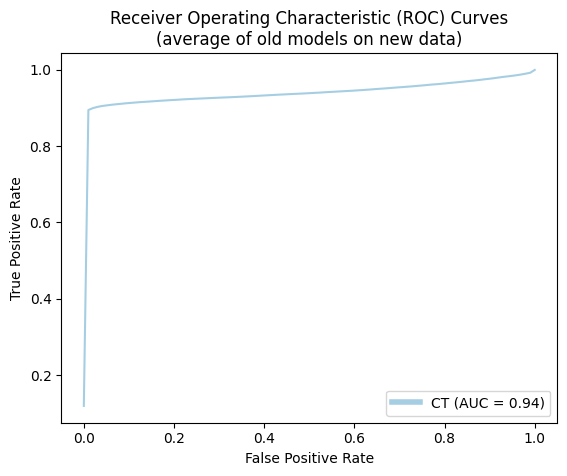

In [24]:
# Placeholder for legend labels and their corresponding AUCs
legend_data = []

for model in ['CT']:# model_data.keys():
    mean_fpr = np.linspace(0, 1, 100)
    tpr_interp = []
    
    for i in range(len(model_fprs[model])):
        fpr = model_fprs[model][i]
        tpr = model_tprs[model][i]
        tpr_interp.append(np.interp(mean_fpr, fpr, tpr))
    
    tpr_array = np.array(tpr_interp)
    avg_tpr = tpr_array.mean(axis=0)
    avg_auc = np.mean(model_aucs[model])

    # Store label and AUC for later sorting
    legend_data.append((model, avg_auc))

    plt.plot(mean_fpr, avg_tpr, color=colors[model], label=f'{model} (AUC = {avg_auc:.2f})')

# Sort the legend data based on AUC in descending order
legend_data.sort(key=lambda x: x[1], reverse=True)

# Create custom legend
custom_legend = [plt.Line2D([0], [0], color=colors[label], lw=4) for label, _ in legend_data]
plt.legend(custom_legend, [f'{label} (AUC = {auc:.2f})' for label, auc in legend_data], loc='lower right')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves\n(average of old models on new data)')
plt.show()

=== CT ===
infile_cols: ['ct_files']; n_input_channels: 1


KeyError: 'in_files'

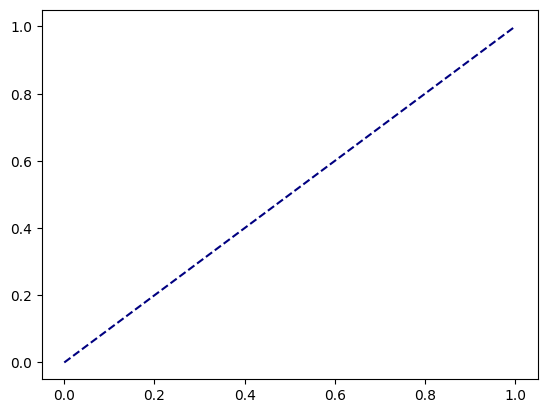

In [12]:
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

total_samples = 0
positive_samples = 0


model_marker_precisions = {}
model_marker_recalls = {}
losses = {}
for model in model_data.keys():
    print(f"=== {model} ===")

    df = pd.DataFrame(model_data[model])
    infile_cols = [key for key in list(model_data[model].keys()) if key != 'seg_files']
    n_input_channels = len(infile_cols)
    print(f"infile_cols: {infile_cols}; n_input_channels: {n_input_channels}")

    if model == 'CT':
        # determine resampling suggestion
        med_dataset = fastMONAI.vision_all.MedDataset(
            img_list=df.seg_files.tolist(),
            dtype=fastMONAI.vision_all.MedMask
        )
        suggested_voxelsize, requires_resampling = med_dataset.suggestion()
        largest_imagesize = med_dataset.get_largest_img_size(resample=suggested_voxelsize)

    # k validation folds
    kf = KFold(n_splits=k_folds, random_state=random_state, shuffle=True)

    marker_precisions = []
    marker_recalls = []
    precisions = []
    recalls = []
    fprs = []
    tprs = []
    fm_losses = []
    calc_losses = []

    for i, (train_index, valid_index) in enumerate(kf.split(df)):
        if model == 'QSM':
            y_values = df.iloc[valid_index]['seg_files'].tolist()
            for y_file in y_values:
                y_data = np.array(nib.load(y_file).get_fdata() == 1, dtype=int)
                total_samples += y_data.size
                positive_samples += int(y_data.sum())

        dblock = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter(valid_index),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )

        dls = fastMONAI.vision_all.DataLoaders.from_dblock(dblock, df, bs=batch_size)

        learn = fastMONAI.vision_all.Learner(
            dls,
            model=UNet(
                spatial_dims=3,
                in_channels=n_input_channels,
                out_channels=3,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2
            ),
            loss_func=DiceCELoss(
                to_onehot_y=True,
                include_background=True,
                softmax=True,
                weight=ce_loss_weights
            ),
            opt_func=fastMONAI.vision_all.ranger,
            metrics=[fastMONAI.vision_all.multi_dice_score, MarkersIdentified(), SuperfluousMarkers()]#.to_fp16()
        )

        model_file = glob.glob(f"models/{model}-2024*-*-{i}-best*")[0]
        print(model_file)
        learn = learn.load(model_file.replace("models/", "").replace(".pth", ""))

        if torch.cuda.is_available():
            learn.model.cuda()

        # Compute metrics on the entire training dataset
        correct_markers = MarkersIdentified()

        dblock_valid_eval = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter([]),
            get_x=fastMONAI.vision_all.ColReader(infile_cols),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=1, sampler=fastMONAI.vision_all.SequentialSampler)
        for x, y in dls_valid_eval.train:
            print(f"{i}/{len(dls_valid_eval.train)}", end="; ")
            pred = torch.argmax(learn.model(x), dim=1).unsqueeze(1).to(dtype=torch.float)
            correct_markers.accumulate(pred=pred.cpu(), targ=y.cpu())
        
        marker_tps = correct_markers.overlap_count
        marker_fps = correct_markers.pred_marker_count - correct_markers.overlap_count
        marker_fns = correct_markers.targ_marker_count - correct_markers.overlap_count

        marker_precision = (marker_tps / (marker_tps + marker_fps)) if (marker_tps + marker_fps) > 0 else 0
        marker_recall = (marker_tps / (marker_tps + marker_fns))  if (marker_tps + marker_fns) > 0 else 0
        marker_precisions.append(marker_precision)
        marker_recalls.append(marker_recall)

        loss, *metrics = learn.validate(ds_idx=0, dl=dls_valid_eval.train)
        fm_losses.append(metrics[0][0])
        calc_losses.append(metrics[0][1])

        print(f"Marker Precision: {marker_precision}")
        print(f"Marker Recall: {marker_recall}")
        print(f"Loss: {loss}")

        # get predictions
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=len(dls_valid_eval.train_ds), sampler=fastMONAI.vision_all.SequentialSampler)
        valid_x, valid_y = dls_valid_eval.train.one_batch()

        def calc_stuff(x, y):
            pred = learn.model(x)[:,1,:,:,:].unsqueeze(1).cpu().detach().numpy()
            pred -= np.min(pred)
            pred /= np.max(pred)
            pred = pred.flatten()
            targ = (y.cpu() == 1).to(dtype=torch.int).detach().numpy().flatten()

            # calculate AUC
            sample_weight = compute_sample_weight(class_weight="balanced", y=targ, indices=None)
            fpr, tpr, thresholds = roc_curve(targ, pred, sample_weight=sample_weight)
            roc_auc = auc(fpr, tpr)

            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(targ, pred)
            average_precision = average_precision_score(targ, pred)

            return fpr, tpr, precision, recall, thresholds, average_precision, roc_auc

        fpr, tpr, precision, recall, thresholds, average_tpr, roc_auc = calc_stuff(valid_x, valid_y)

        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        tprs.append(tpr)

    if model == 'QSM':
        positive_ratio = positive_samples / total_samples
        #plt.hlines(positive_ratio, xmin=0, xmax=1, color='navy', linestyle='--')

    model_marker_precisions[model] = [np.mean(marker_precisions), np.std(marker_precisions)]
    model_marker_recalls[model] = [np.mean(marker_recalls), np.std(marker_recalls)]
    losses[model] = [np.mean(fm_losses), np.std(fm_losses), np.mean(calc_losses), np.std(calc_losses)]
    
    # define a common set of recall values
    common_recall = np.linspace(0, 1, 100)

    # initialize an empty array to hold the interpolated precisions
    interpolated_precisions = []

    for precision, recall in zip(precisions, recalls):
        # reverse the arrays because recall should be non-decreasing for interpolation
        precision = precision[::-1]
        recall = recall[::-1]

        # interpolate the precision values to the common recall values
        interpolated_precision = np.interp(common_recall, recall, precision)
        
        # store the interpolated precision
        interpolated_precisions.append(interpolated_precision)

    # calculate the average precision at each common recall value
    average_precision = np.mean(interpolated_precisions, axis=0)

    prc_auc = auc(common_recall, average_precision)

    # plot the average precision-recall curve
    plt.plot(common_recall, average_precision, color=colors[model], label=f'{model} (AUC = {round(prc_auc, 2)})')

    if model == 'QSM':
        positive_ratio = np.mean([y.mean() for _, y in dls_valid_eval.train])  # assuming y contains binary labels with 1s for positive samples.
        plt.hlines(positive_ratio, xmin=0, xmax=1, color='navy', linestyle='--')

    del learn, dls, dblock_valid_eval, dls_valid_eval, loss, metrics, valid_x, valid_y, correct_markers

print(model_marker_precisions)
print(model_marker_recalls)
print(losses)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curves\n(Average over {k_folds}-fold cross-validation)')
#plt.legend(loc="lower right")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # to ensure that all the elements fit into the figure area
plt.savefig("poc-curves-marker.png", dpi=400)
plt.show()

In [ ]:
import seaborn as sns

# Convert the dictionary to a pandas dataframe
df = pd.DataFrame(model_marker_precisions).transpose().reset_index()
df.columns = ['Model', 'Mean', 'Std']

# Create a barplot using seaborn
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Model', y='Mean', yerr=df['Std'], capsize=.2)

plt.title('Precision Across Models')
plt.ylabel('Precision')
plt.xlabel('Models')
plt.show()

In [ ]:
# Convert the dictionary to a pandas dataframe
df = pd.DataFrame(model_marker_recalls).transpose().reset_index()
df.columns = ['Model', 'Mean', 'Std']

# Create a barplot using seaborn
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Model', y='Mean', yerr=df['Std'], capsize=.2)

plt.title('Recall Across Models')
plt.ylabel('Recall')
plt.xlabel('Models')
plt.show()

In [ ]:
# Convert the dictionary to a pandas dataframe
prec_df = pd.DataFrame(model_marker_precisions).transpose().reset_index()
rec_df = pd.DataFrame(model_marker_recalls).transpose().reset_index()

# Add Metric column to differentiate between Precision and Recall
prec_df['Metric'] = 'Precision'
rec_df['Metric'] = 'Recall'

prec_df.columns = ['Model', 'Mean', 'Std', 'Metric']
rec_df.columns = ['Model', 'Mean', 'Std', 'Metric']

# Combine both dataframes
df = pd.concat([prec_df, rec_df])

In [ ]:
# Convert 'Mean' and 'Std' to the desired string format
df['Mean +/- Std'] = df.apply(lambda row: f'{round(row["Mean"], 2)} +/- {round(row["Std"], 2)}', axis=1)

# Pivot the table to get the desired format
df_pivot = df.pivot(index='Model', columns='Metric', values='Mean +/- Std').reset_index()

# Rename the columns to 'Recall' and 'Precision'
df_pivot.columns = ['Model', 'Precision', 'Recall']
df_pivot = df_pivot.sort_values('Precision', ascending=False)

In [ ]:
df_pivot

In [ ]:
# Create a grouped barplot using seaborn
plt.figure(figsize=(12,8))
barplot = sns.barplot(data=df, x='Model', y='Mean', hue='Metric', capsize=.2)

# Add error bars manually
for i, model in enumerate(df['Model'].unique()):
    model_data = df[df['Model'] == model]
    precision_data = model_data[model_data['Metric'] == 'Precision']
    recall_data = model_data[model_data['Metric'] == 'Recall']
    barplot.errorbar(x=i - 0.2, y=precision_data['Mean'].values[0], yerr=precision_data['Std'].values[0], color='black', capsize=3)
    barplot.errorbar(x=i + 0.2, y=recall_data['Mean'].values[0], yerr=recall_data['Std'].values[0], color='black', capsize=3)

plt.ylim(0, 1.05)
plt.title('Marker-level Precision and Recall across Models')
plt.ylabel('Score')
plt.xlabel('Models')
plt.show()

In [ ]:
losses

In [ ]:
# Initialize lists to hold the data
model_list = []
region_list = []
mean_list = []
std_list = []

# Loop over the dictionary
for model, values in losses.items():
    # Add 'FM' region values
    model_list.append(model)
    region_list.append('FM')
    mean_list.append(values[0])
    std_list.append(values[1])
    
    # Add 'Calc' region values
    model_list.append(model)
    region_list.append('Calc')
    mean_list.append(values[2])
    std_list.append(values[3])

# Create the DataFrame
losses_df = pd.DataFrame({
    'Model': model_list,
    'Region': region_list,
    'Mean': mean_list,
    'Std': std_list
})
losses_df

In [ ]:
# Create a grouped barplot using seaborn
plt.figure(figsize=(12,8))
barplot = sns.barplot(data=losses_df, x='Model', y='Mean', hue='Region', capsize=.2)

# Add error bars manually
for i, model in enumerate(losses_df['Model'].unique()):
    for j, region in enumerate(losses_df['Region'].unique()):
        model_data = losses_df[losses_df['Model'] == model]
        model_data = model_data[model_data['Region'] == region]
        barplot.errorbar(x=i - 0.2 + 0.4*j, y=model_data['Mean'].values[0], yerr=model_data['Std'].values[0], color='black', capsize=3)

plt.ylim(0, 1.0)
plt.title('Dice scores across models and regions')
plt.ylabel('Dice score')
plt.xlabel('Models')
plt.show()

In [ ]:
pred_calc_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*pred_calc.nii*")) for session_dir in session_dirs), []))
pred_seed_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*pred_seed.nii*")) for session_dir in session_dirs), []))
pred_empty_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*pred_empty.nii*")) for session_dir in session_dirs), []))
pred_seg_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*pred_seg.nii*")) for session_dir in session_dirs), []))

assert(len(qsm_files) == len(pred_calc_files))
assert(len(qsm_files) == len(pred_seed_files))
assert(len(qsm_files) == len(pred_empty_files))
assert(len(qsm_files) == len(pred_seg_files))

In [ ]:
input_images = qsm_files
#input_segmentations = ct_seg_clean_files
#raw_segmentations = ct_seg_raw_files
input_segmentations = gre_seg_clean_files
raw_segmentations = gre_seg_raw_files
#clip_data = (0, 100)
clip_data = None
#vrange = (0, 1000) # T1w
#vrange = (0, 0.75) # SWI
vrange = (-0.5, +0.5) # QSM
#vrange = (0, 800) # GRE
crop_size = 20
half_cropsize = crop_size // 2

regions_vals = []
regions_masks = []
regions_pred_segs = []
regions_subjects = []
regions_pred_seeds = []
regions_pred_calcs = []

In [ ]:

for i in range(len(input_segmentations)):
    # load images
    subject = input_segmentations[i].split(os.sep)[1]
    seg = nib.load(input_segmentations[i]).get_fdata()
    input_data = nib.load(input_images[i]).get_fdata()
    pred_seg_data = nib.load(pred_seg_files[i]).get_fdata()
    pred_seed_data = nib.load(pred_seed_files[i]).get_fdata()
    pred_calc_data = nib.load(pred_calc_files[i]).get_fdata()

    if clip_data is not None:
        input_data[input_data == np.inf] = clip_data[1]
        input_data[input_data < 0] = clip_data[0]
        input_data[input_data > 100] = clip_data[1]
        input_data[np.isnan(input_data)] = 0

    # get regions
    centroids = get_centroids(mask=seg == SegTypeClean.GOLD_SEED.value)

    for j in range(len(centroids)):
        seg_submask = seg[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        pred_seg_submask = pred_seg_data[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        pred_seed_submask = pred_seed_data[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        pred_calc_submask = pred_calc_data[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        subvals = input_data[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        regions_vals.append(subvals)
        regions_masks.append(seg_submask)
        regions_pred_segs.append(pred_seg_submask)
        regions_pred_seeds.append(pred_seed_submask)
        regions_pred_calcs.append(pred_calc_submask)
        regions_subjects.append(subject)

In [ ]:


print("Creating figure")
fig, axes = plt.subplots(ncols=4, nrows=len(regions_vals), figsize=(10, 180))

for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

for i in range(len(regions_vals)):
    try:
        axes[i,0].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vrange[0], vmax=vrange[1], interpolation='nearest')
        
        axes[i,1].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vrange[0], vmax=vrange[1], interpolation='nearest')
        axes[i,1].imshow(regions_masks[i][regions_vals[i].shape[0]//2,:,:], cmap='tab10', alpha=np.array(regions_masks[i][regions_vals[i].shape[0]//2,:,:], dtype=float), vmin=1, vmax=9)

        axes[i,2].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vrange[0], vmax=vrange[1], interpolation='nearest')
        axes[i,2].imshow(regions_pred_segs[i][regions_vals[i].shape[0]//2,:,:], cmap='tab10', alpha=np.array(regions_pred_segs[i][regions_vals[i].shape[0]//2,:,:], dtype=float), vmin=1, vmax=9)

        axes[i,3].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vrange[0], vmax=vrange[1], interpolation='nearest')
        seed_alphamap = regions_pred_seeds[i][regions_vals[i].shape[0]//2,:,:] > 0
        calc_alphamap = regions_pred_calcs[i][regions_vals[i].shape[0]//2,:,:] > 0
        calc_alphamap = np.logical_and(calc_alphamap, calc_alphamap > seed_alphamap)
        calc_alphamap = np.logical_and(calc_alphamap, regions_pred_segs[i][regions_vals[i].shape[0]//2,:,:] != 2)
        axes[i,3].imshow(regions_pred_seeds[i][regions_vals[i].shape[0]//2,:,:], cmap='winter', alpha=np.array(seed_alphamap, dtype=float), vmin=0.01, vmax=15)
        axes[i,3].imshow(regions_pred_calcs[i][regions_vals[i].shape[0]//2,:,:], cmap='autumn', alpha=np.array(calc_alphamap, dtype=float), vmin=0.01, vmax=15)
    except:
        continue
    axes[i,0].set_ylabel(regions_subjects[i], rotation=0, fontsize=12, labelpad=55)

#print("Saving figure")
plt.savefig("seeds_qsm_preds.png", bbox_inches='tight', dpi=200)

print("Displaying figure")
plt.show()
plt.close()